In [1]:
import sys
import os
import re
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
from load_dataset import load, generate_random_dataset
from classifier import *
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from operator import itemgetter
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
val_seeds = [42, 99, 67, 2, 23]
val_seed = val_seeds[3]

seed = 1
c = 0.003
epoch_num = 3000
th = 0.03

In [4]:
dataset = 'hmda'
sens_attr = 'race'
scenario = 4

In [5]:
A = 'y'
A_val = 1
# A = None
# A_val = None
fair_metric = 0 if (A is None) else 1
assert (A=='y' and A_val==1) or (A==None)

In [6]:
clf_name = 'LogisticRegression'

## Preparation

**Load Dataset**

In [7]:
X_train, X_test, y_train, y_test = load(dataset)

**Parametric Model**

In [8]:
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Loss function** (Log loss for logistic regression)

In [9]:
# clf = NeuralNetwork(input_size=X_train.shape[-1])
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM(input_size=X_train.shape[-1])
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch

**Compute Accuracy** 

In [10]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**Metrics: Initial state**

In [11]:
clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.22299553839176234
Initial TPR parity:  -0.17254657839525755
Initial predictive parity:  -0.17299121772233284
Initial loss:  0.4197703977276468
Initial accuracy:  0.8186919504643962


In [12]:
X_train_orig.columns

Index(['race', 'gender', 'loan_type', 'applicant_age', 'lien_status', 'LV',
       'DI', 'income_brackets'],
      dtype='object')

Correlation Ranking

In [13]:
for col in X_test_orig.columns:
    print(f'corr. between {col} and label: {np.round(np.corrcoef(X_test_orig[col], y_test)[0][1], 2)}')

corr. between race and label: 0.24
corr. between gender and label: 0.14
corr. between loan_type and label: 0.19
corr. between applicant_age and label: -0.0
corr. between lien_status and label: -0.01
corr. between LV and label: -0.13
corr. between DI and label: -0.17
corr. between income_brackets and label: 0.29


In [14]:
for col in X_test_orig.columns:
    print(f'corr. between {col} and {sens_attr}: {np.round(np.corrcoef(X_test_orig[col], X_test_orig[sens_attr])[0][1], 2)}')

corr. between race and race: 1.0
corr. between gender and race: 0.22
corr. between loan_type and race: -0.03
corr. between applicant_age and race: -0.01
corr. between lien_status and race: -0.05
corr. between LV and race: -0.21
corr. between DI and race: -0.14
corr. between income_brackets and race: 0.24


In [15]:
clf.lr.weight

Parameter containing:
tensor([[ 0.3278,  0.0170,  0.7890, -0.0778,  0.0584, -0.5675, -0.1824,  0.5923]],
       requires_grad=True)

### Definition

In [16]:
def train_clf(model, info_dict):
    val_iter = 10
    epoch = model.epoch_num
    model.epoch_num = val_iter
    val_num = epoch // val_iter
    min_loss = 2048
    best_model = None
    for _ in range(val_num):
        model.fit_info(info_dict)
        loss = model.compute_loss(info_dict)
        if loss < min_loss:
            torch.save(model.state_dict(), 'best_params/best.pth')
            min_loss = loss
    model.load_state_dict(torch.load('best_params/best.pth'))
    model.eval()
    return model

In [17]:
def get_A_idx(x, y, A=None, A_val=None):
    if A is None:
        return x.index
    elif A == 'y':
        return y[y==A_val].index
    else:
        raise NotImplementedError

In [18]:
def get_attr(x, y, attr):
    if attr=='y':
        return y
    else:
        return x[attr]

In [19]:
def record_statistics(clf, record=True):
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled,
                            y_train_sampled, fair_metric, dataset)
    if record:
        BFs.append(-spd_0)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train,
                            fair_metric, dataset)
    if record:
        AFs.append(-spd_0)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    ub = np.max(score_privileged_groups)-np.min(score_protected_groups)
    lb = -np.max(score_protected_groups)+np.min(score_privileged_groups)

    print(f'Upper Bound: {ub}')
    print(f'Lower Bound: {lb}')

    if record:
        ubs.append(ub)
        lbs.append(lb)

## Inject Selection Bias

### HDMA scenario 1

In [20]:
indicator = ((dataset=='hmda') and (scenario==1))

In [21]:
# if indicator:
#     data = pd.read_csv('races_White-Black or African American_loan_purposes_1_year_2019.csv')

In [22]:
# if indicator:
#     tbar = tqdm.tqdm(total=53)
#     spds = []
#     accs = []
#     tprs = []

#     for state in data.state_code.unique()[~pd.isna(data.state_code.unique())]:
#         df = data[data['state_code']==state].reset_index(drop=True)
#     #     df = pd.read_csv('state_CO_races_White-Black or African American_loan_purposes_1.csv')
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [23]:
# if indicator:
#     state = 'CA'
#     df = data[data['state_code']==state].reset_index(drop=True)
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

#     print(f'--------------- STATE: {state} ---------------')

#     clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#     clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#     y_pred_test = clf.predict_proba(X_test)
#     y_pred_train = clf.predict_proba(X_train)

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

In [24]:
# if indicator:
#     txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
#     cc = '22099'
#     df = data[data['county_code']==int(cc)].reset_index(drop=True)
#     county, state = re.findall(f'<td>{cc}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     X_test = sc.transform(X_test)
    
#     y_pred_test = clf.predict_proba(X_test)
    
#     print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

In [25]:
# if indicator:
#     print(df[(df['race']==0)].applicant_age.value_counts()/df[(df['race']==1)].applicant_age.value_counts())

In [26]:
# if indicator:
#     cc = '06067'
#     top_counties = list(data[data['state_code']=='LA'].county_code.value_counts().iloc[:20].to_dict().keys())
#     top_counties = [str(int(c)) for c in top_counties]
#     txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
#     spds = []
#     accs = []
#     tprs = []
#     tbar = tqdm.tqdm(total=20)

#     for c in top_counties:
#         county, state = re.findall(f'<td>{"0"*(5-len(c))+c}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
#         df = data[data['county_code']==float(c)].reset_index(drop=True)
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [27]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==0], label='black', alpha=0.5, range=(1, 3))
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==1], label='white', alpha=0.5, range=(1, 3))
    plt.xticks([1, 2, 3], )
    plt.legend()
    plt.xlabel('DI (divided by gender)')

In [28]:
if indicator:
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==0], label='black', alpha=0.5, bins=3)
    plt.show()

In [29]:
if indicator:
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==1], label='white', alpha=0.5, bins=3)
    plt.show()

**Sample based on the conditional probability**

In [30]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.race==0)&(X_train_orig.DI==2)] = 0.1
    p[(X_train_orig.race==0)&(X_train_orig.DI==3)] = 0.2
    p[(X_train_orig.race==1)&(X_train_orig.DI==1)] = 0.1
    plt.hist(p, bins=10)
    plt.show()

In [31]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [32]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [33]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [34]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [35]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'DI'
    parent_2 = 'race'
    parent_3 = 'race'

**Bound**

In [36]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 4

In [37]:
indicator = ((dataset=='hmda') and (scenario==4))

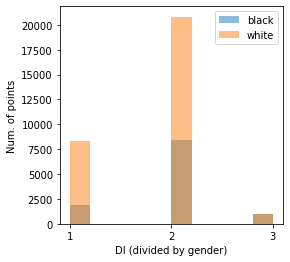

In [38]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==0], label='black', alpha=0.5, range=(1, 3))
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==1], label='white', alpha=0.5, range=(1, 3))
    plt.xticks([1, 2, 3], )
    plt.legend()
    plt.xlabel('DI (divided by gender)')

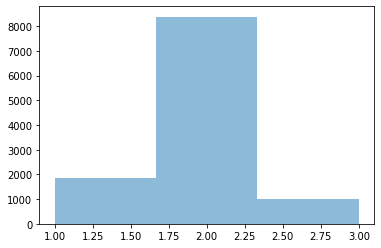

In [39]:
if indicator:
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==0], label='black', alpha=0.5, bins=3)
    plt.show()

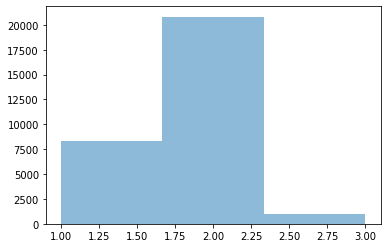

In [40]:
if indicator:
    plt.hist(X_train_orig.DI[X_train_orig[sens_attr]==1], label='white', alpha=0.5, bins=3)
    plt.show()

**Sample based on the conditional probability**

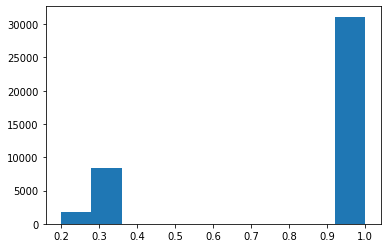

In [41]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.race==0)&(X_train_orig.DI==1)] = 0.2
    p[(X_train_orig.race==0)&(X_train_orig.DI==2)] = 0.3
    plt.hist(p, bins=10)
    plt.show()

In [42]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [43]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [44]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.2706552664961235
Initial TPR parity:  -0.22177416931196992
Initial predictive parity:  -0.1684569936255581
Initial loss:  0.42378901439525246
Initial accuracy:  0.8173374613003096


In [45]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.3247737720477214
Initial accuracy:  0.8483628240550232


In [46]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'DI'
    parent_2 = 'race'
    parent_3 = 'race'

**Bound**

In [47]:
if indicator:
    record_statistics(clf, record=False)

BF:  0.2161150605396911
AF:  0.21509849161722372
Upper Bound: 0.34967291355133057
Lower Bound: 0.004272520542144775


### Adult scenario 1: make collider to be the child of relationship and gender (try to use sampling to eliminate the correlation between them on the training set)

In [48]:
indicator = ((dataset=='adult') and (scenario==1))

In [49]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(X_train_orig.relationship[X_train_orig.gender==0], label='female', alpha=0.5, range=(0, 1))
    plt.hist(X_train_orig.relationship[X_train_orig.gender==1], label='male', alpha=0.5, range=(0, 1))
    plt.xticks([0, 1], ['not-married', 'married'])
    plt.legend()
    plt.xlabel('relationship (divided by gender)')

In [50]:
if indicator:
    print(np.sum(X_train_orig.relationship[X_train_orig.gender==0])/np.sum(X_train_orig.relationship[X_train_orig.gender==1]))

**Pr(C=1|married,female)=1, Pr(C=1|not_married,high)=1, Pr(C=1|married,male)=0.11, Pr(C=1|not_married,low)=1**

In [51]:
# generate Pr(C=1|gender, income) for each training data point
if indicator:
    p = np.where(np.logical_and(X_train_orig.relationship, X_train_orig.gender), 0.11, 1.0)
    plt.hist(p)
    plt.show()

**Sample based on the conditional probability**

In [52]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [53]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [54]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [55]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [56]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'gender'
    parent_3 = 'gender'

**Bound**

In [57]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

### Adult scenario 4: make collider to be the child of relationship and gender (try to use sampling to increase the correlation between them on the training set)

In [58]:
indicator = ((dataset=='adult') and (scenario==4))

In [59]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(X_train_orig.relationship[X_train_orig.gender==0], label='female', alpha=0.5, range=(0, 1))
    plt.hist(X_train_orig.relationship[X_train_orig.gender==1], label='male', alpha=0.5, range=(0, 1))
    plt.xticks([0, 1], ['not-married', 'married'])
    plt.legend()
    plt.xlabel('relationship (divided by gender)')

In [60]:
if indicator:
    print(np.sum(X_train_orig.relationship[X_train_orig.gender==0])/np.sum(X_train_orig.relationship[X_train_orig.gender==1]))

In [61]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
#     p[(X_train_orig.relationship==1)&(X_train_orig.gender==0)] = 0.5
    p[(X_train_orig.relationship==0)&(X_train_orig.gender==1)] = 0.5
    plt.hist(p)
    plt.show()

**Sample based on the conditional probability**

In [62]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [63]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [64]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [65]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [66]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'gender'
    parent_3 = 'gender'

**Bound**

In [67]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

### Adult scenario 2: make collider to be the child of relationship and education (try to use sampling to increase the correlation between gender and label on the training set)

In [68]:
indicator = ((dataset=='adult') and (scenario==2))

In [69]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(X_train_orig.education[X_train_orig.relationship==0], label='not-married', alpha=0.5, range=(0, 3))
    plt.hist(X_train_orig.education[X_train_orig.relationship==1], label='married', alpha=0.5, range=(0, 3))
    plt.xticks(range(4))
    plt.legend()
    plt.xlabel('hours (divided by relationship)')

**Pr(C=1|married,female)=1, Pr(C=1|not_married,high)=1, Pr(C=1|married,male)=0.11, Pr(C=1|not_married,low)=1**

In [70]:
# generate Pr(C=1|gender, income) for each training data point
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==1)&(X_train_orig.education==0)] = 0.2
    p[(X_train_orig.relationship==1)&(X_train_orig.education==1)] = 0.4
    p[(X_train_orig.relationship==1)&(X_train_orig.education==2)] = 0.6
    p[(X_train_orig.relationship==0)&(X_train_orig.education==1)] = 0.6
    p[(X_train_orig.relationship==0)&(X_train_orig.education==2)] = 0.4
    p[(X_train_orig.relationship==0)&(X_train_orig.education==3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [71]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [72]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [73]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [74]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [75]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'education'
    parent_3 = 'relationship'

**Bound**

In [76]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 3: make collider to be the child of relationship and label (try to use sampling to increase the correlation between gender and label on the training set)

In [77]:
indicator = ((dataset=='adult') and (scenario==3))

In [78]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    plt.hist(y_train[X_train_orig.relationship==0], label='not-married', alpha=0.5, range=(0, 1))
    plt.hist(y_train[X_train_orig.relationship==1], label='married', alpha=0.5, range=(0, 1))
    plt.xticks(range(2))
    plt.legend()
    plt.xlabel('label (divided by relationship)')

**Pr(C=1|married,female)=1, Pr(C=1|not_married,high)=1, Pr(C=1|married,male)=0.11, Pr(C=1|not_married,low)=1**

In [79]:
# generate Pr(C=1|gender, income) for each training data point
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==1)&(y_train==0)] = 0.2
    p[(X_train_orig.relationship==0)&(y_train==1)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [80]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [81]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [82]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [83]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [84]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'y'
    parent_3 = 'relationship'

**Bound**

In [85]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 1: make collider to be the child of relationship and gender (try to use sampling to eliminate the correlation between them on the training set)

In [86]:
indicator = ((dataset=='law') and (scenario==1))

In [87]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        for v in range(2):
            numerator = len(X_train_orig[(X_train_orig.racetxt==1)&(X_train_orig.decile3==u)&(X_train_orig.lsat==v)].index)
            denominator = len(X_train_orig[(X_train_orig.racetxt==0)&(X_train_orig.decile3==u)&(X_train_orig.lsat==v)].index)
            numerators.append(numerator)
            denominators.append(denominator)
            ratio = numerator/denominator
            ratios.append(ratio)

    plt.bar(range(4), numerators, alpha=0.5, label='white')
    plt.bar(range(4), denominators, alpha=0.5, label='non-white')
    plt.xticks(range(4), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('decile3+lsat (divided by race)')

In [88]:
# generate Pr(C=1|race, decile3, lsat) for each training data point
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.racetxt==0)&(X_train_orig.decile3==0)&(X_train_orig.lsat==0)] = ratios[0]/ratios[2]
    p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==0)&(X_train_orig.lsat==1)] = ratios[2]/ratios[1]
    p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==1)&(X_train_orig.lsat==1)] = ratios[2]/ratios[3]
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [89]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [90]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [91]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [92]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [93]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'decile3'
    parent_2 = 'lsat'
    parent_3 = 'racetxt'

**Bound**

In [94]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

### Law scenario 2: make collider to be the child of lsat and decile3 (try to use sampling to increase the correlation between label and race on the training set)

In [95]:
indicator = ((dataset=='law') and (scenario==2))

In [96]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        numerator = len(X_train_orig[(X_train_orig.decile3==u)&(X_train_orig.lsat==0)].index)
        denominator = len(X_train_orig[(X_train_orig.decile3==u)&(X_train_orig.lsat==1)].index)
        numerators.append(numerator)
        denominators.append(denominator)
        ratio = numerator/denominator
        ratios.append(ratio)

    plt.bar(range(2), numerators, alpha=0.5, label='low lsat')
    plt.bar(range(2), denominators, alpha=0.5, label='high lsat')
    plt.xticks(range(2), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('decile3 (divided by lsat)')

In [97]:
# generate Pr(C=1|race, decile3, lsat) for each training data point
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==1)&(X_train_orig.decile3==0)] = 0.1
    p[(X_train_orig.lsat==0)&(X_train_orig.decile3==1)] = 0.3
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [98]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [99]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [100]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        numerator = len(X_train_orig_sampled[(X_train_orig_sampled.decile3==u)&(X_train_orig_sampled.lsat==0)].index)
        denominator = len(X_train_orig_sampled[(X_train_orig_sampled.decile3==u)&(X_train_orig_sampled.lsat==1)].index)
        numerators.append(numerator)
        denominators.append(denominator)
        ratio = numerator/denominator
        ratios.append(ratio)

    plt.bar(range(2), numerators, alpha=0.5, label='low lsat')
    plt.bar(range(2), denominators, alpha=0.5, label='high lsat')
    plt.xticks(range(2), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('decile3 (divided by lsat)')

In [101]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [102]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [103]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'decile3'
    parent_2 = 'lsat'
    parent_3 = 'lsat'

**Bound**

In [104]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

### Law scenario 3: make collider to be the child of lsat and label (try to use sampling to increase the correlation between label and race on the training set)

In [105]:
indicator = ((dataset=='law') and (scenario==3))

In [106]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        numerator = len(X_train_orig[(y_train==u)&(X_train_orig.lsat==0)].index)
        denominator = len(X_train_orig[(y_train==u)&(X_train_orig.lsat==1)].index)
        numerators.append(numerator)
        denominators.append(denominator)
        ratio = numerator/denominator
        ratios.append(ratio)

    plt.bar(range(2), numerators, alpha=0.5, label='low lsat')
    plt.bar(range(2), denominators, alpha=0.5, label='high lsat')
    plt.xticks(range(2), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('label (divided by lsat)')

In [107]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==1)&(y_train==0)] = 0.3
    p[(X_train_orig.lsat==0)&(y_train==1)] = 0.1
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [108]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [109]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [110]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        numerator = len(X_train_orig_sampled[(X_train_orig_sampled.decile3==u)&(X_train_orig_sampled.lsat==0)].index)
        denominator = len(X_train_orig_sampled[(X_train_orig_sampled.decile3==u)&(X_train_orig_sampled.lsat==1)].index)
        numerators.append(numerator)
        denominators.append(denominator)
        ratio = numerator/denominator
        ratios.append(ratio)

    plt.bar(range(2), numerators, alpha=0.5, label='low lsat')
    plt.bar(range(2), denominators, alpha=0.5, label='high lsat')
    plt.xticks(range(2), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('decile3 (divided by lsat)')

In [111]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [112]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [113]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'lsat'
    parent_2 = 'lsat'
    parent_3 = 'y'

**Bound**

In [114]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

## Regularizer

In [115]:
BFs = []
AFs = []
ubs = []
lbs = []
accs = []

### Prepare Validation Set

In [116]:
X_train_orig_sampled, X_val_orig_sampled, y_train_sampled, y_val_sampled = \
    train_test_split(X_train_orig_sampled, y_train_sampled, test_size=0.25, random_state=val_seed)

In [117]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_val_sampled = sc.transform(X_val_orig_sampled)
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_val_orig_sampled = X_val_orig_sampled.reset_index(drop=True)
y_train_sampled = y_train_sampled.reset_index(drop=True)
y_val_sampled = y_val_sampled.reset_index(drop=True)
X_test = sc.transform(X_test_orig)
X_train = sc.transform(X_train_orig)

### Definition

In [118]:
def train_clf(model, info_dict):
    val_iter = 10
    epoch = model.epoch_num
    model.epoch_num = val_iter
    val_num = epoch // val_iter
    min_loss = 2048
    best_model = None
    for _ in range(val_num):
        model.fit_info(info_dict)
        loss = model.compute_loss(info_dict)
        if loss < min_loss:
            torch.save(model.state_dict(), 'best_params/best.pth')
            min_loss = loss
    model.load_state_dict(torch.load('best_params/best.pth'))
    model.eval()
    return model

In [119]:
def get_A_idx(x, y, A=None, A_val=None):
    if A is None:
        return x.index
    elif A == 'y':
        return y[y==A_val].index
    else:
        raise NotImplementedError

In [120]:
def get_attr(x, y, attr):
    if attr=='y':
        return y
    else:
        return x[attr]

In [121]:
def record_statistics(clf, record=True):
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled,
                            y_train_sampled, fair_metric, dataset)
    if record:
        BFs.append(-spd_0)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train,
                            fair_metric, dataset)
    if record:
        AFs.append(-spd_0)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    ub = np.max(score_privileged_groups)-np.min(score_protected_groups)
    lb = -np.max(score_protected_groups)+np.min(score_privileged_groups)

    print(f'Upper Bound: {ub}')
    print(f'Lower Bound: {lb}')

    if record:
        ubs.append(ub)
        lbs.append(lb)

### No Regularizer

In [122]:
info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

In [123]:
clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
accs.append(accuracy_0)

Initial statistical parity:  -0.2706270531884327
Initial TPR parity:  -0.22232522599342885
Initial predictive parity:  -0.16873341023133714
Initial loss:  0.42445496337544936
Initial accuracy:  0.8172407120743034


In [124]:
record_statistics(clf)

BF:  0.21538866575951776
AF:  0.21557142634275184
Upper Bound: 0.33818840980529785
Lower Bound: 0.018077611923217773


### Bound Regularizer

In [125]:
info_dict = dict()
info_dict['th'] = th
info_dict['balance'] = 3
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

In [126]:
clf = LogisticRegression_Reg_Bound(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
accs.append(accuracy_0)

Initial statistical parity:  -0.0462812949079725
Initial TPR parity:  -0.018363869861475313
Initial predictive parity:  -0.20737198740613616
Initial loss:  0.45183077994817106
Initial accuracy:  0.7963428792569659


In [127]:
record_statistics(clf)

BF:  0.007385583776853832
AF:  0.012920552648187145
Upper Bound: 0.02199256420135498
Lower Bound: -0.010255396366119385


### Metric Regularizer

In [128]:
info_dict = dict()
info_dict['th'] = th
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
privileged_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
info_dict['train_regularizer'] = [protected_idx, privileged_idx]

protected_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
privileged_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
info_dict['val_regularizer'] = [protected_idx, privileged_idx]

In [129]:
clf = LogisticRegression_Reg_Metric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
accs.append(accuracy_0)

Initial statistical parity:  -0.039349378614665254
Initial TPR parity:  -0.0038388390258314864
Initial predictive parity:  -0.20214663320594262
Initial loss:  0.4456531692528991
Initial accuracy:  0.8147252321981424


In [130]:
record_statistics(clf)

BF:  0.002894173505154307
AF:  0.0010304045230561387
Upper Bound: 0.14430737495422363
Lower Bound: -0.19858896732330322


### Weighted Metric Regularizer

In [131]:
info_dict = dict()
info_dict['th'] = th
info_dict['balance'] = 2
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

weights = [[], []]
for s in range(2):
    s_idx = X_train_orig[X_train_orig[sens_attr]==s].index.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig[(get_attr(X_train_orig, y_train, parent_1)==v) &\
                                   (get_attr(X_train_orig, y_train, parent_2)==u) &\
                                   (get_attr(X_train_orig, y_train, parent_3)==w) &\
                                   (get_attr(X_train_orig, y_train, sens_attr)==s)].index
                idx = idx.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
                if len(idx)>0:
                    weights[s].append(len(idx)/len(s_idx))

info_dict['weights'] = weights


In [132]:
clf = LogisticRegression_Reg_WeightedMetric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
accs.append(accuracy_0)

Initial statistical parity:  -0.07334542979361713
Initial TPR parity:  -0.034290775100295434
Initial predictive parity:  -0.19682905912148974
Initial loss:  0.43495944929784036
Initial accuracy:  0.8228521671826625


In [133]:
record_statistics(clf)

BF:  0.031471286262445
AF:  0.030101972948798572
Upper Bound: 0.166850745677948
Lower Bound: -0.16599011421203613


### Est. Weighted Metric Regularizer (limited info)

In [134]:
# class LogisticRegression_Reg_EstWeightedMetric(LogisticRegression):
#     def __init__(self, input_size, learning_rate=0.005, c=0.01, epoch_num=300):
#         torch.manual_seed(seed)
#         super(LogisticRegression_Reg_EstWeightedMetric, self).__init__(input_size, learning_rate, c, epoch_num)
#         self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

#     def fit(self, x, y, external_data_weights, regularizer=None, balance=1, th=0):
#         '''external_data_weights corresponds to the conditional distribution: Pr(U|S,A)'''
#         torch.manual_seed(0)
#         x = torch.Tensor(x)
#         y = torch.Tensor(y)
#         self.train()
#         for _ in range(self.epoch_num):
#             loss = self.criterion(self, x, y)
#             if regularizer is not None:
#                 weighted_privileged = 0
#                 for u_idx, u in enumerate(regularizer[1]):
#                     weighted_privileged += external_data_weights[1][u_idx]*torch.mean(self(x[u]))
#                 weighted_protected = 0
#                 for u_idx, u in enumerate(regularizer[0]):
#                     weighted_protected += external_data_weights[0][u_idx]*torch.mean(self(x[u]))
#                 add_loss = torch.abs(weighted_privileged - weighted_protected)
#                 loss += balance*torch.clamp(add_loss, min=th)
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()
        
#     def fit_info(self, info_dict):
#         th = info_dict['th'] # initialized with 0
#         x, y = info_dict['x_train'], info_dict['y_train']
#         regularizer = info_dict['train_regularizer']
#         extl_info = info_dict['extl_info']
#         base_clf = info_dict['base_clf']
#         external_data_weights = self.Pr_U_SY(base_clf, extl_info)
#         info_dict['weights'] = external_data_weights
#         if 'balance' in info_dict.keys():
#             balance = info_dict['balance']
#         else:
#             balance = 0.5
#         self.fit(x, y, external_data_weights, regularizer, balance, th)
        
#     def compute_loss(self, info_dict):
#         self.eval()
#         th = info_dict['th'] # initialized with 0
#         x, y = info_dict['x_val'], info_dict['y_val']
#         regularizer = info_dict['val_regularizer']
#         external_data_weights = info_dict['weights']
#         loss = self.criterion(self, x, y).detach().numpy()
#         add_loss = np.abs(self.compute_AF_est(info_dict))
#         loss += add_loss
#         return loss
    
#     def compute_AF_est(self, info_dict):
#         self.eval()
#         x, y = info_dict['x_val'], info_dict['y_val']
#         regularizer = info_dict['val_regularizer']
#         external_data_weights = info_dict['weights']
#         weighted_privileged = 0
#         for u_idx, u in enumerate(regularizer[1]):
#             weighted_privileged += external_data_weights[1][u_idx]*np.mean(self.predict_proba(x[u]))
#         weighted_protected = 0
#         for u_idx, u in enumerate(regularizer[0]):
#             weighted_protected += external_data_weights[0][u_idx]*np.mean(self.predict_proba(x[u]))
#         est = weighted_privileged - weighted_protected
#         return est
    
#     def Pr_U_SY(self, base_clf, ext_info):
#         ext_idx = ext_info['idx']
#         ext_sidx = ext_info['sidx']
#         ext_data = ext_info['data']
#         weights = [[], []]
#         for u in range(len(ext_idx[0])):
#             for s in range(2):
#                 len_s = len(ext_sidx[s])
#                 len_su = len(ext_data[ext_idx[s][u]])
#                 numerator = np.sum(base_clf.predict_proba(ext_data[ext_idx[s][u]]))
#                 Pr_Y_U = [base_clf.predict_proba(ext_data[ext_idx[s][u1]]) for u1 in range(len(ext_idx[0]))]
#                 denominator = np.sum(np.concatenate(Pr_Y_U))
#                 weights[s].append(numerator/denominator)
#         return weights

In [135]:
info_dict = dict()
extl_info = dict()
info_dict['th'] = th
info_dict['balance'] = 2
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

extl_info['data'] = X_train
idxs = [[], []]
for s in range(2):
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==s)].index
                idx_unbiased = X_train_orig[(get_attr(X_train_orig, y_train, parent_1)==v) &\
                                            (get_attr(X_train_orig, y_train, parent_2)==u) &\
                                            (get_attr(X_train_orig, y_train, parent_3)==w) &\
                                            (get_attr(X_train_orig, y_train, sens_attr)==s)].index
                idx_a = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx_a)>0:
                    idxs[s].append(len(idx_a)/len(idx)*len(idx_unbiased))

weights = [[], []]
for s in range(2):
    weights[s] = [w/sum(idxs[s]) for w in idxs[s]]
info_dict['weights'] = weights

In [136]:
# clf = LogisticRegression_Reg_EstWeightedMetric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)
clf = LogisticRegression_Reg_WeightedMetric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
accs.append(accuracy_0)

Initial statistical parity:  -0.07188037725351881
Initial TPR parity:  -0.033037642796385325
Initial predictive parity:  -0.1970959439949871
Initial loss:  0.4352338955079689
Initial accuracy:  0.8228521671826625


In [137]:
record_statistics(clf)

BF:  0.030221084772750317
AF:  0.02887549258586819
Upper Bound: 0.1644219160079956
Lower Bound: -0.1657124161720276


### Adversarial Debiasing

In [138]:
class LogisticRegression_AD(LogisticRegression):
    def __init__(self, input_size, learning_rate=0.005, adv_learning_rate=0.4, c=0.01, epoch_num=300):
        torch.manual_seed(seed)
        super(LogisticRegression_AD, self).__init__(input_size, learning_rate, c, epoch_num)
#         self.c = torch.Tensor(1)
        self.c = 1
        self.lr2 = nn.Linear(3, 1)
#         self.criterion_adv = torch.nn.CrossEntropyLoss()
        self.criterion_adv = torch.nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.lr.parameters(), lr=learning_rate, momentum=0.9)
        self.adv_optimizer = torch.optim.SGD(self.lr2.parameters(), lr=adv_learning_rate, momentum=0.9)
        self.clf_layers = [self.lr]
#         self.adv_layers = [self.lr2, self.c]
        self.adv_layers = [self.lr2]
    
    def forward_adv(self, x, y):
#         s = torch.nn.Sigmoid()((1+torch.abs(self.c))*self.lr(x)).ravel()
        s = torch.nn.Sigmoid()((1+self.c)*self.lr(x)).ravel()
        z_tilda = torch.nn.Sigmoid()(self.lr2(torch.stack([s, s*y, s*(1-y)], dim=1)))
        return z_tilda
    
    def loss_adv(self, x, y, z):
        z_tilda = self.forward_adv(x, y)
        loss = self.criterion_adv(z_tilda, z)
        return loss
    
    def fit(self, x, y, z, th=1, balance=0.5, load=True):
        '''external_data_weights corresponds to the conditional distribution: Pr(U|S,A)'''
        torch.manual_seed(0)
        spds = []
        accs = []
        acc_advs = []
        min_loss = 1
        max_acc = 0
        orig_balance = balance
        saved_flag = False
        x = torch.Tensor(x)
        x.requires_grad = False
        y = torch.Tensor(y)
        y.requires_grad = False
        z = torch.Tensor(z).reshape(-1, 1)
        z.requires_grad = False
        self.train()
        for e in range(self.epoch_num):
            for layer in self.clf_layers:
                layer.requires_grad = False
            for layer in self.adv_layers:
                layer.requires_grad = True
            adv_loss = self.loss_adv(x, y, z)
            self.adv_optimizer.zero_grad()
            adv_loss.backward()
            self.adv_optimizer.step()

            for layer in self.clf_layers:
                layer.requires_grad = True
            for layer in self.adv_layers:
                layer.requires_grad = False
            loss = self.criterion(self, x, y)-balance*self.loss_adv(x, y, z)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if (e%10)==0:
                y_pred_val = self.predict_proba(X_val_sampled)
                spd_0 = computeFairness(y_pred_val, X_val_orig_sampled, y_val_sampled, fair_metric, dataset)
                spds.append(spd_0)
                accuracy_0 = computeAccuracy(y_val_sampled, y_pred_val)
                accs.append(accuracy_0)
                if np.abs(spd_0) < min_loss:
                    min_loss = np.abs(spd_0)
                    torch.save(self.state_dict(), 'best_params/best.pth')
                    saved_flag = True
#                 if np.abs(spd_0) < th:
#                     if accuracy_0 > max_acc:
#                         max_acc = accuracy_0
#                         torch.save(self.state_dict(), 'best_params/best.pth')
#                         saved_flag = True
#                         balance = orig_balance                        
                
#                 if accuracy_0 > max_acc:
#                     max_acc = accuracy_0

                zt = self.forward_adv(x, y).detach().numpy()
                zt = np.where(zt>0.5, 1, 0).ravel()
                acc_advs.append(np.sum(zt==z.detach().numpy().ravel())/len(zt))
#             print(e)
        if saved_flag and load:
            self.load_state_dict(torch.load('best_params/best.pth'))
        self.eval()
        return spds, accs, acc_advs
        
#     def fit_info(self, info_dict):
#         th = info_dict['th'] # initialized with 0
#         x, y = info_dict['x_train'], info_dict['y_train']
#         regularizer = info_dict['train_regularizer']
#         extl_info = info_dict['extl_info']
#         base_clf = info_dict['base_clf']
#         external_data_weights = self.Pr_U_SY(base_clf, extl_info)
#         info_dict['weights'] = external_data_weights
#         if 'balance' in info_dict.keys():
#             balance = info_dict['balance']
#         else:
#             balance = 0.5
#         self.fit(x, y, external_data_weights, regularizer, balance, th)
        
    def compute_loss(self, info_dict):
        self.eval()
        th = info_dict['th'] # initialized with 0
        x, y = info_dict['x_val'], info_dict['y_val']
        regularizer = info_dict['val_regularizer']
        external_data_weights = info_dict['weights']
        loss = self.criterion(self, x, y).detach().numpy()
        add_loss = np.abs(self.compute_AF_est(info_dict))
        loss += add_loss
        return loss

In [139]:
clf = LogisticRegression_AD(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c,
                            learning_rate=0.01, adv_learning_rate=0.2)
spds, accs, acc_advs = clf.fit(X_train_sampled, y_train_sampled, X_train_orig_sampled[sens_attr],
                               th=0.1, balance=0.4, load=True)

In [140]:
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.05625101864971116
Initial TPR parity:  -0.02705647629496777
Initial predictive parity:  -0.20375594148556142
Initial loss:  0.4517806690071399
Initial accuracy:  0.8227554179566563


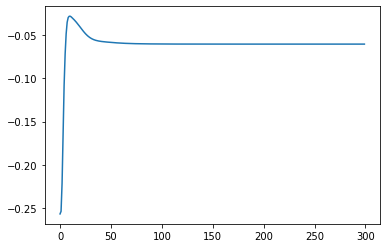

In [141]:
plt.plot(spds)

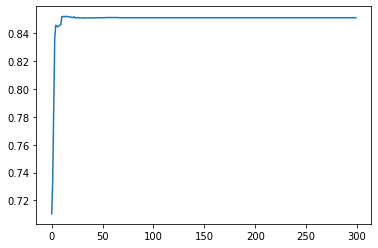

In [142]:
plt.plot(accs)

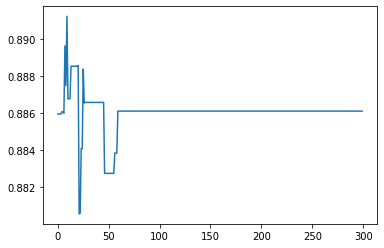

In [143]:
plt.plot(acc_advs)

In [144]:
record_statistics(clf)

BF:  0.027859684236079985
AF:  0.025103393274080177
Upper Bound: 0.15329408645629883
Lower Bound: -0.1561053991317749


## Record Results

In [145]:
# rearange_idx = [0, 2, 5, 1, 3, 4]

In [146]:
# plt.figure(figsize=(8, 5))
# plt.plot(range(len(AFs)), np.array(AFs)[rearange_idx], color='black', lw=3)
# plt.fill_between(range(len(AFs)), np.array(lbs)[rearange_idx], np.array(ubs)[rearange_idx], color='blue', alpha=0.5)
# plt.xticks(range(len(AFs)), np.array(['Orig', 'Bound Reg.', 'BF Reg.', 'AF Reg.', 'Est.AF Reg.', 'Adv. Debias'])[rearange_idx])
# plt.ylabel('EO' if fair_metric else 'SPD')
# plt.show()

In [147]:
AFs, BFs, ubs, lbs

([0.21557142634275184,
  0.012920552648187145,
  0.0010304045230561387,
  0.030101972948798572,
  0.02887549258586819,
  0.025103393274080177],
 [0.21538866575951776,
  0.007385583776853832,
  0.002894173505154307,
  0.031471286262445,
  0.030221084772750317,
  0.027859684236079985],
 [0.3381884, 0.021992564, 0.14430737, 0.16685075, 0.16442192, 0.15329409],
 [0.018077612,
  -0.010255396,
  -0.19858897,
  -0.16599011,
  -0.16571242,
  -0.1561054])

In [148]:
dict_name = '_'
if fair_metric == 1:
    dict_name = 'EO' + dict_name
elif fair_metric == 0:
    dict_name = 'SPD' + dict_name
else:
    raise NotImplementedError

if clf_name == 'LogisticRegression':
    dict_name = dict_name + 'LR'
elif clf_name == 'SVM':
    dict_name = dict_name + 'SVM'
elif clf_name == 'NeuralNetwork':
    dict_name = dict_name + 'NN'
else:
    raise NotImplementedError

dict_name = dict_name + '.dict'

with open(dict_name, 'r') as f:
    txt = f.read()
d = json.loads(txt)
name = ['Orig', 'Bound Reg.', 'BF Reg.', 'AF Reg.', 'Est.AF Reg.', 'Adv. Debias']
for n_idx, n in enumerate(name):
    if f'sc{scenario}' not in d[dataset]:
        d[dataset][f'sc{scenario}'] = dict()
        for vs in val_seeds:
            d[dataset][f'sc{scenario}'][str(vs)] = dict()
    d[dataset][f'sc{scenario}'][str(val_seed)][n] = [float(AFs[n_idx]), float(BFs[n_idx]),
                                                     float(ubs[n_idx]), float(lbs[n_idx]), float(accs[n_idx])]
txt = json.dumps(d)
with open(dict_name, 'w+') as f:
    f.write(txt)

In [149]:
# for fm in ['EO', 'SPD']:
#     for mt in ['LR', 'SVM', 'NN']:
#         if (fm=='EO') and (mt=='LR'):
#             continue
#         else:
#             d = dict()
#             d['adult'] = dict()
#             d['law'] = dict()
#             d['hmda'] = dict()
#             for k in d.keys():
#                 d[k] = dict()
#                 for sc in range(1, 4):
#                     d[k][f'sc{sc}'] = dict()
#                     for seed in val_seeds:
#                         d[k][f'sc{sc}'][seed] = dict()
#             txt = json.dumps(d)

#             with open(f'{fm}_{mt}.dict', 'w+') as f:
#                 f.write(txt)
#                 f.close()

In [150]:
with open(dict_name, 'r') as f:
    txt = f.read()
d = json.loads(txt)
d

{'adult': {'sc1': {'42': {},
   '99': {'Orig': [0.2000245669543202,
     0.021895842202268312,
     0.44138458371162415,
     -0.2900835871696472,
     0.3977954513743547],
    'Bound Reg.': [0.013129147576902422,
     -0.0010074393162201878,
     0.01924137771129608,
     -0.022099420428276062,
     0.48834937909864656],
    'BF Reg.': [0.18907611181324807,
     0.017670586664067733,
     0.42073073983192444,
     -0.2821056842803955,
     0.5738105204409097],
    'AF Reg.': [0.043927070563982484,
     -0.09951278893064347,
     0.2629251480102539,
     -0.3659147024154663,
     0.7108274033765871],
    'Est.AF Reg.': [0.04490907814745998,
     -0.09887513280279298,
     0.26413971185684204,
     -0.36573460698127747,
     0.7458490302776615],
    'LFR': [0.17627232834479117,
     -0.027057831166844737,
     0.4746578633785248,
     -0.3963463604450226,
     0.8054448871181938],
    'Reweighing': [0.16292435919775022,
     -0.018351482161859833,
     0.3999987542629242,
     -0.328212

In [151]:
# df_dict = dict()
# df_dict[' '] = ['Orig', 'Reweighing', 'LFR', 'BF Reg.', 'Bound Reg.', 'AF Reg.', 'Est.AF Reg.']
# for ds in ['Adult', 'Law']:
#     for sc in range(1, 4):
#         df_dict[f'{ds} Scenario-{sc}'] = [round(d[ds.lower()][f'sc{sc}']['99'][method][0], 4) for method in df_dict[' ']]

In [152]:
# pd.DataFrame(df_dict).to_latex()

In [153]:
# print(pd.DataFrame(df_dict).to_latex(index=False))

In [154]:
# d[ds.lower()][f'sc{sc}']['99']['BF Reg.']

In [155]:
# fig = plt.figure(figsize=(8, 4), dpi=200)
# ax = plt.subplot(111)
# ax.set_facecolor('#E5E4E2')
# ax.grid(color='w', linestyle='solid')
# sc_dict = d['law'][f'sc{3}']['99']
# for i in range(len(df_dict[' '])):
#     m = df_dict[' '][i]
#     if i==0:
#         plt.errorbar(i, sc_dict[m][0], xerr=0.2, color='red', capthick=2, label='AF')
#         plt.errorbar(i, sc_dict[m][1], xerr=0.2, color='blue', capthick=2, label='BF')
#         plt.errorbar(i, (sc_dict[m][2]+sc_dict[m][3])/2,
#                      yerr=abs(sc_dict[m][2]-sc_dict[m][3])/2, color='black', elinewidth=1)
#         plt.errorbar(i, sc_dict[m][2], xerr=0.1, color='black', capthick=2, label='Bounds')
#         plt.errorbar(i, sc_dict[m][3], xerr=0.1, color='black', capthick=2)
#     else:
#         plt.errorbar(i, sc_dict[m][0], xerr=0.2, color='red', capthick=2)
#         plt.errorbar(i, sc_dict[m][1], xerr=0.2, color='blue', capthick=2)
#         plt.errorbar(i, (sc_dict[m][2]+sc_dict[m][3])/2,
#                      yerr=abs(sc_dict[m][2]-sc_dict[m][3])/2, color='black', elinewidth=1)
#         plt.errorbar(i, sc_dict[m][2], xerr=0.1, color='black', capthick=2)
#         plt.errorbar(i, sc_dict[m][3], xerr=0.1, color='black', capthick=2)

# # for spine in ax.spines.values():
# #     spine.set_visible(False)
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     # spine.set_visible(False)

# ax.tick_params(top=False)
# ax.tick_params(right=False)
# ax.tick_params(labeltop=False)
# ax.tick_params(labelright=False)

# ax.xaxis.tick_bottom()
# ax.yaxis.tick_left()
# ax.set_axisbelow(True)

# ax.tick_params(colors='white', direction='out')
# for tick in ax.get_xticklabels():
#     tick.set_fontsize(12)
#     tick.set_color('black')
# for tick in ax.get_yticklabels():
#     tick.set_color('black')
#     tick.set_fontsize(12)

# ax.legend(fontsize=16, fancybox=False, framealpha=0)
# plt.tight_layout()
# plt.xticks(range(len(df_dict[' '])), df_dict[' '])
# # plt.savefig('scatter_debias.pdf', dpi=400)
# plt.show()